In [2]:
# Utils
import pickle

# Data
import pandas as pd
import numpy as np

# Type
from dataclasses import dataclass
from enum import Enum
from typing import List, Dict, Any, Tuple
from abc import ABC

# Plotting
import matplotlib.pyplot as plt 
import seaborn as sns


In [3]:
df = pd.read_pickle('../test-data/numerics_df.pkl')

In [4]:
df[('metadata','grad')] = df[('metadata','grad')].apply(lambda x: TensorType.Activation if not x else TensorType.Gradient)

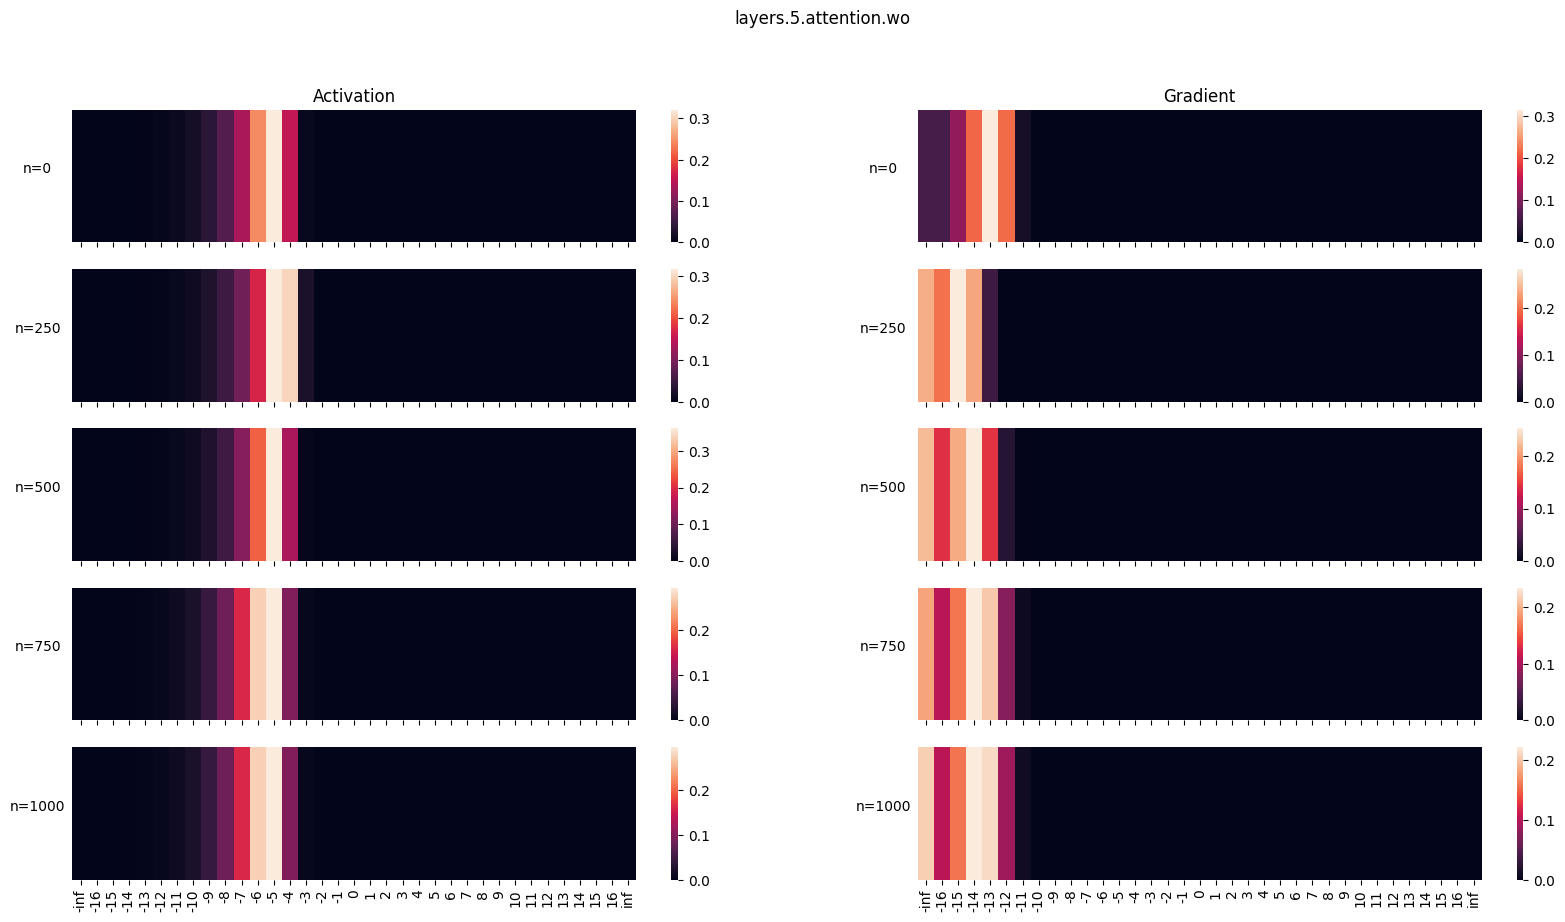

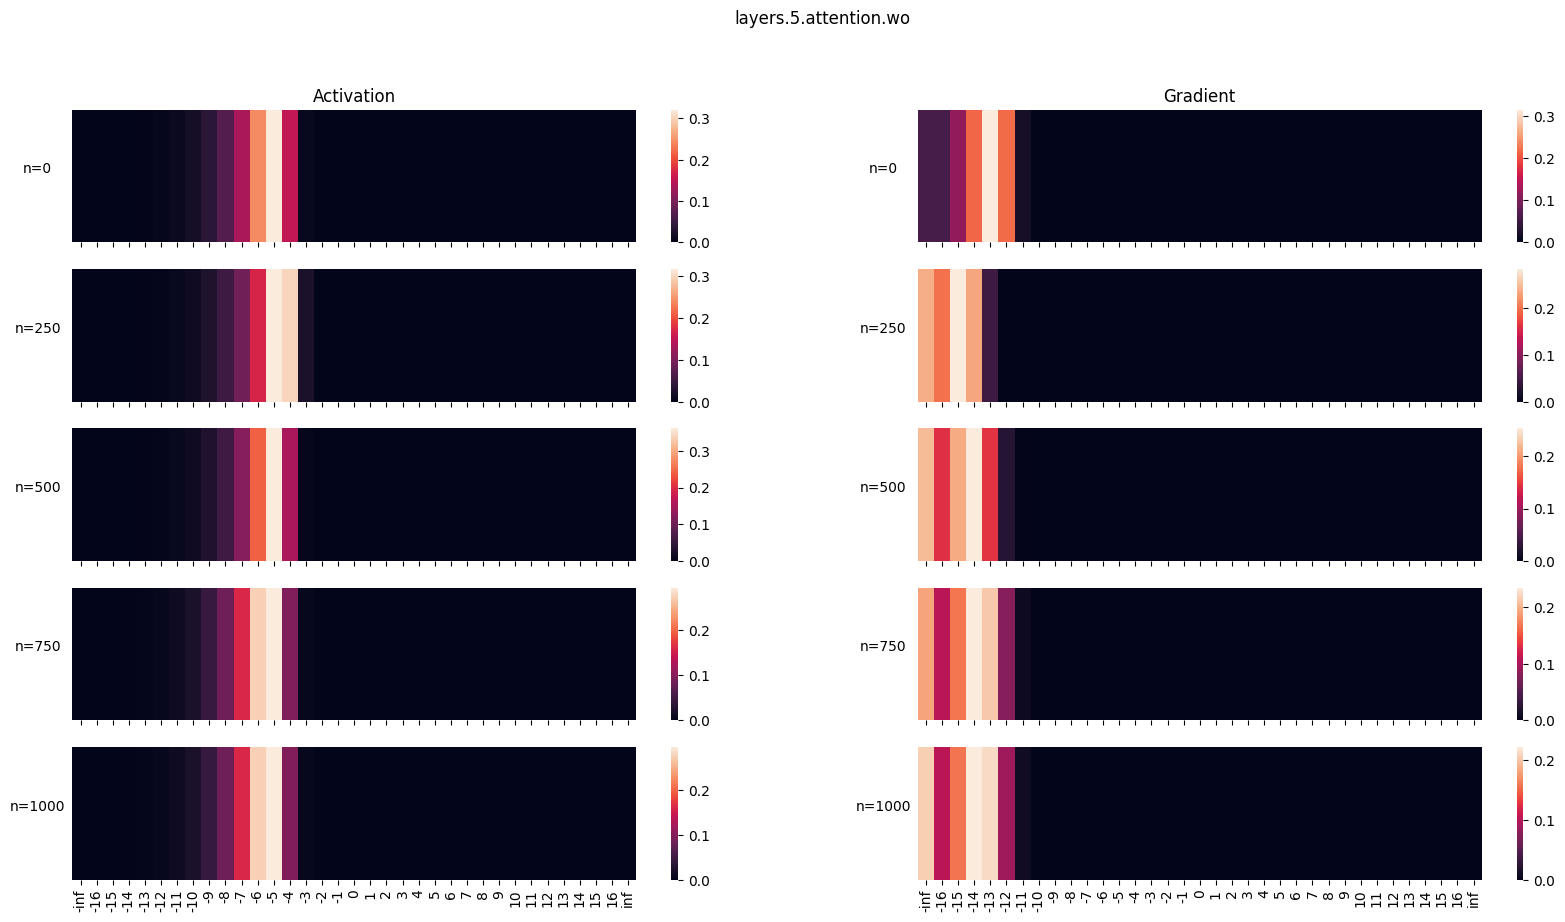

In [5]:

def plot_single_layer_temporal_heat_map(
        log: pd.DataFrame, 
        layer_name: str, 
        fig_title: str = None, 
        interval: int =  50, 
        exclude_tensor_types: List[TensorType] = [],
        figsize: Tuple[int,int] = (20,10)):
    """
        nrows: total_its // interval
        ncols: Num tensor types you're logging (i.e. gradients, activations, weights, optimiser_state)


        TO-DO: 
            Global colour legend & unify scales
    """
    # multi-index tuples
    which_tensor = ('metadata', 'grad') # to index for activations vs. gradients
    which_it = ('metadata', 'step')
    which_layer = ('metadata', 'name')

    assert layer_name in log[which_layer].unique(), f'{layer_name} is not in the logs provided'
    assert np.array_equal(log[which_it].unique(), log[log[which_layer] == layer_name][which_it].unique()) == True, f'{layer_name} has not been logged for each training iteration' # perhaps this should be change to ensure all interval are in the steps column

    mod_log = log[log[which_layer] == layer_name] # df for layer in question only

    final_it = mod_log[which_it].max()
    assert final_it % interval == 0, 'Interval must be a multiple of total number of iterations'
    n_rows = final_it // interval + 1 # to ensure final step is displayed.
    # should probably do some soft warning if figsize[1] / n_rows is below some threshold for certain plots
    tensors_logged = [t_inc for t_inc in mod_log[which_tensor].unique() if t_inc not in exclude_tensor_types]
    # disable interactive plotting (so fn doesn't print)
    with plt.ioff():
        # intialise sub plots
        fig, axs = plt.subplots(ncols=len(tensors_logged), nrows=n_rows, figsize=figsize, sharex='col', sharey='row')

        # loop for generating subplots\
        # iterate over rows
        for it,ax in zip(range(0,final_it+1, interval),axs):

            mod_it_log = mod_log[mod_log[which_it] == it] #filter df for interval it
            # iterate over columns
            for j,col in enumerate(ax):
                # logic for column titles:
                tensor_tbd = tensors_logged[j]
                if it == 0:
                    col.set_title(tensor_tbd.name)

                # draw subplot
                mod_it_tensor_log = mod_it_log[mod_it_log[which_tensor] == tensor_tbd]
                denom = mod_it_tensor_log.exponent_count.sum(axis =1)
                normed_mod_it_tensor_log = mod_it_tensor_log.exponent_count.apply(lambda x: x/denom)

                # temp fix to order exponent column
                col_list = normed_mod_it_tensor_log.columns.to_list()
                col_list = col_list[-2:-1] + col_list[:-2] + col_list[-1:]

                # generate some plot -> 
                sns.heatmap(normed_mod_it_tensor_log[col_list],ax=col)
                
                # can be reusable acorss plot types (of this nature)
                col.set_yticks([])
                col.set_ylabel(f'n={it}', rotation=0, fontsize=10, labelpad=25)
    
        if fig_title:
            fig.suptitle(fig_title)
        else:
            fig.suptitle(layer_name)
    return fig

plot_single_layer_temporal_heat_map(df,layer_name='layers.5.attention.wo',interval=250)

In [6]:
def plot_single_module_layer_mean_temporal_heatmap(
        log: pd.DataFrame, 
        layer_regex: str, 
        fig_title: str = None, 
        interval: int =  50, 
    exclude_tensor_types: List[TensorType] = None,
        figsize: Tuple[int,int] = (20,10)):

    
    # multi-index tuples
    which_tensor = ('metadata', 'grad') # to index for activations vs. gradients
    which_it = ('metadata', 'step')
    which_layer = ('metadata', 'name')
    which_module = ('metadata', 'type')

    # could perhaps generate these queries from the data structures rather than hard coding them?
    # temp =df.query(f"@df.metadata.name.str.contains('{layer_regex}$')")
    # .pipe(lambda x: x[x.metadata.grad == False]).groupby(
        # df.metadata.type).exponent_count.sum()
    
    plotted_df = None

    mod_log = log.query(f"@log.metadata.name.str.contains('{layer_regex}$')") # df for layer(s) in question only

    assert not mod_log.empty, f'{layer_regex} is not in the logs provided'
    # assert len(log[which_it].unique()) log[log[which_layer] == layer_regex][which_it].unique()) == True, f'{layer_regex} has not been logged for each training iteration' # perhaps this should be change to ensure all interval are in the steps column
    # # checking if there's logs for every layer (from regex) for every step
    # len(temp.groupby([('metadata','name'),('metadata','step')]).size())
    
    # .pipe(
    # lambda x : x[x.metadata.step == 0])

    final_it = mod_log[which_it].max()
    assert final_it % interval == 0, 'Interval must be a multiple of total number of iterations'
    n_rows = final_it // interval + 1 # to ensure final step is displayed.
    # should probably do some soft warning if figsize[1] / n_rows is below some threshold for certain plots
    if exclude_tensor_types:
        tensors_logged = [t_inc for t_inc in mod_log[which_tensor].unique() if t_inc not in exclude_tensor_types]
    else:
        tensors_logged = mod_log[which_tensor].unique()


    # disable interactive plotting (so fn doesn't print)
    with plt.ioff():
        
        # intialise sub plots
        fig, axs = plt.subplots(ncols=len(tensors_logged), nrows=n_rows, figsize=figsize, sharex='col', sharey='row')

        # loop for generating subplots\
        # iterate over rows
        for it,ax in zip(range(0,final_it+1, interval),axs):

            mod_it_log = mod_log[mod_log[which_it] == it] #filter df for interval it
            # iterate over columns
            for j,col in enumerate(ax):
                # logic for column titles:
                tensor_tbd = tensors_logged[j]
                if it == 0:
                    col.set_title(tensor_tbd.name)

                # filter by tensor type
                mod_it_tensor_log = mod_it_log[mod_it_log[which_tensor] == tensor_tbd]

                # group by layer type (i.e. torch.nn.modules.linear.Linear) and get the sum across exponent counts; if need to perform a check to ensure the exponent columns are consistent (i.e. E4M3 used for some & E5M2 used for others)
                grouped_mod_it_tensor_log = mod_it_tensor_log.groupby(which_module).exponent_count.sum() # is sum valid here?
                # get total count
                denom = grouped_mod_it_tensor_log.exponent_count.sum(axis =1)
                # normalise
                normed_grouped_mod_it_tensor_log = grouped_mod_it_tensor_log.exponent_count.apply(lambda x: x/denom)

                # temp fix to order exponent column
                col_list = normed_grouped_mod_it_tensor_log.columns.to_list()
                col_list = col_list[-2:-1] + col_list[:-2] + col_list[-1:]
                
                if not isinstance(plotted_df,pd.DataFrame):
                    plotted_df = normed_grouped_mod_it_tensor_log[col_list]
                # generate some plot -> 
                sns.heatmap(normed_grouped_mod_it_tensor_log[col_list],ax=col)
                
                # can be reusable acorss plot types (of this nature)
                col.set_yticks([])
                col.set_ylabel(f'n={it}', rotation=0, fontsize=10, labelpad=25)
    
    if fig_title:
        fig.suptitle(fig_title)
    else:
        fig.suptitle(layer_regex)
    return fig


    
ending_in = "[0-9].attention.wk"
    
f = plot_single_module_layer_mean_temporal_heatmap(df,"[0-9].attention.wq",interval=500)

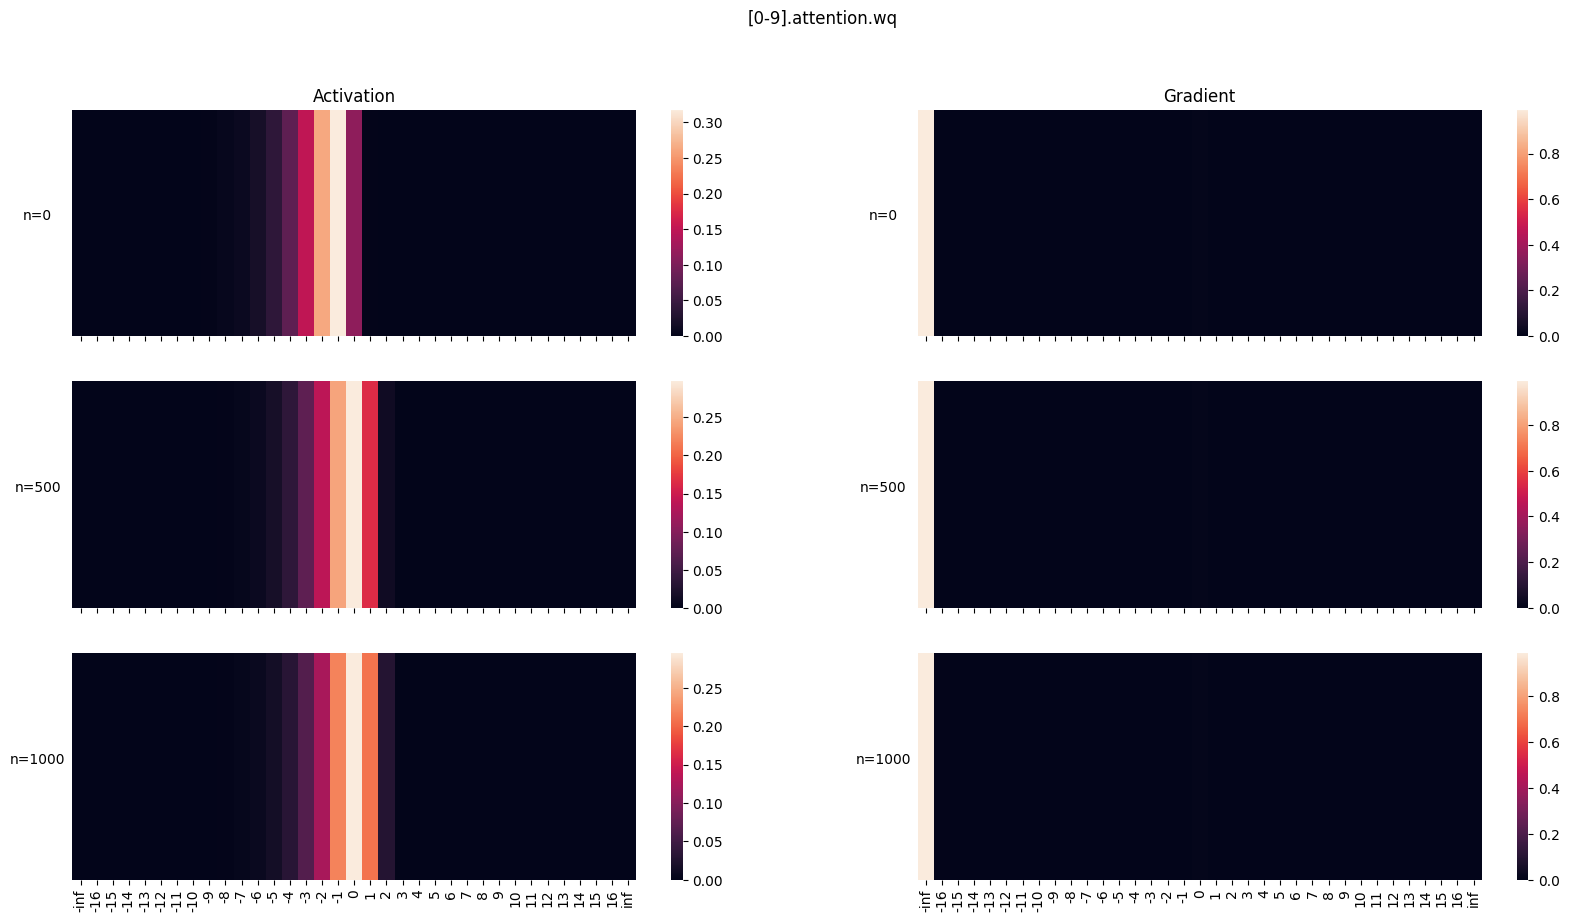

In [7]:
f

In [14]:
# ending_in = "[0-9].attention.wk"
# # could perhaps generate these queries from the data structures rather than hard coding them?
# temp =df.query(f"@df.metadata.name.str.contains('{ending_in}$')")

In [25]:
def global_vis(log: pd.DataFrame, scalar_metric: str = 'rm2', interval: int = 1):
    """
        Zoomed out view based on entire set of logs w.r.t. some scalar metric
    """

    # assert input is correct
    assert scalar_metric in log.general_stats.columns, f"Please choose a value from the following, {' '.join(df.general_stats.columns)}"

    # assert that all tensors have this metric for all iterations
    log[('metadata','step')]

    with plt.ioff():
        fig = sns.heatmap()


        return fig


In [6]:
temp = df.pipe(lambda x: x[x[('metadata','grad')]== TensorType.Activation]).pipe(lambda x: x[x.metadata.step < 10])[[('metadata','name'), ('metadata','step'), ('general_stats','rm2')]]

In [8]:
# n_steps x n_layers 


metadata                                \
                                         name                                 
('metadata', 'step')                        0    1    2    3    4    5    6   
0                              tok_embeddings  NaN  NaN  NaN  NaN  NaN  NaN   
1                                     dropout  NaN  NaN  NaN  NaN  NaN  NaN   
2                     layers.0.attention_norm  NaN  NaN  NaN  NaN  NaN  NaN   
3                       layers.0.attention.wq  NaN  NaN  NaN  NaN  NaN  NaN   
4                       layers.0.attention.wk  NaN  NaN  NaN  NaN  NaN  NaN   
...                                       ...  ...  ...  ...  ...  ...  ...   
1449                                      NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1450                                      NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1451                                      NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1452                                      NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1453                                      NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                                                              general_stats  \
                                                                        rm2   
('metadata', 'step')    7    8                              9             0   
0                     NaN  NaN                            NaN      0.020015   
1                     NaN  NaN                            NaN      0.020015   
2                     NaN  NaN                            NaN      0.987686   
3                     NaN  NaN                            NaN      0.315506   
4                     NaN  NaN                            NaN      0.314945   
...                   ...  ...                            ...           ...   
1449                  NaN  NaN  layers.5.feed_forward.dropout           NaN   
1450                  NaN  NaN                       layers.5           NaN   
1451                  NaN  NaN                           norm           NaN   
1452                  NaN  NaN                         output           NaN   
1453                  NaN  NaN                                          NaN   

                                                                
                                                                
('metadata', 'step')   1   2   3   4   5   6   7   8         9  
0                    NaN NaN NaN NaN NaN NaN NaN NaN       NaN  
1                    NaN NaN NaN NaN NaN NaN NaN NaN       NaN  
2                    NaN NaN NaN NaN NaN NaN NaN NaN       NaN  
3                    NaN NaN NaN NaN NaN NaN NaN NaN       NaN  
4                    NaN NaN NaN NaN NaN NaN NaN NaN       NaN  
...                   ..  ..  ..  ..  ..  ..  ..  ..       ...  
1449                 NaN NaN NaN NaN NaN NaN NaN NaN  0.008010  
1450                 NaN NaN NaN NaN NaN NaN NaN NaN  0.050159  
1451                 NaN NaN NaN NaN NaN NaN NaN NaN  0.997934  
1452                 NaN NaN NaN NaN NaN NaN NaN NaN  0.319606  
1453                 NaN NaN NaN NaN NaN NaN NaN NaN  0.319606  

[770 rows x 20 columns]